# Introduction 
In this tutorial, we demonstrate how to use Monocle 2 to resolve the complicated haematopoiesis process which involves two major branch points (HSC bifurcates into either megakaryote/erythroid progenitor (MEP) or granulocyte/monocyte progenitor (GMP) and the bifurcation from GMP into either granulocyte and monocyte progenitor) by applying reversed graph embedding (RGE). The reconstructed developmental trajectory is learned in four dimensions but can be visualized in two dimensions. With the trajectory learned we are able to identify genes showing significant bifurcation pattern during each lineage bifurcation through BEAM (\cite{}). We can furhter combine ChIP-seq datasets for Gfi1 (granulocyte master regulator) and Irf8 (monocyte master regulator) as well as the transcription factors to build a regulatory network from master regulators to other important downstream regulators and then those regulators to their downstream targets. This network hiearchy is promising to resolve the fundamental regulatory mechanism for the haematopoiesis. We also provided multi-way heatmap / kinetic curves to visualize important marker genes over the differentiation process. Some additional analysis are included, which are used for the tutorial on analyzing the Paul dataset.  

This notebook reproduces figures shown in Figure 2 of the Monocle 2 paper. 

# Load the libraries 
- options(warn=-1) used to turn off warninig 
- helper function to identify the root cell 

In [1]:
rm(list = ls()) # clear the environment 
options(warn=-1) # turn off warning message globally 

# helper function to set the root state correctly 
get_correct_root_state <- function(cds){
  T0_counts <- table(pData(cds)$State, pData(cds)$Type)[,"Lsk"]
  as.numeric(names(T0_counts)[which(T0_counts == max(T0_counts))])
}

####################################################################################################################################################################################
#load all package
####################################################################################################################################################################################
suppressMessages(library(monocle))
suppressMessages(library(stringr))
suppressMessages(library(plyr))
suppressMessages(library(netbiov))

# Prepare the cds for both of the full dataset
- read in the expression matrix in FPKM values 
- create a CDS 
- convert the FPKM values to relative census counts 
- create another CDS storing the relative census counts 

In [2]:
#reading the exprs data and create a cell dataset:

hta_exprs <- read.csv("./Olsson_RSEM_SingleCellRNASeq.csv",row.names=1)
sample_sheet <- data.frame(groups = str_split_fixed(colnames(hta_exprs), "\\.+", 3), row.names = colnames(hta_exprs))
gene_ann <- data.frame(gene_short_name = row.names(hta_exprs), row.names = row.names(hta_exprs))
pd <- new("AnnotatedDataFrame",data=sample_sheet)
fd <- new("AnnotatedDataFrame",data=gene_ann)

tpm_mat <- hta_exprs
tpm_mat <- apply(tpm_mat, 2, function(x) x / sum(x) * 1e6)

URMM_all_std <- newCellDataSet(as.matrix(tpm_mat),phenoData = pd,featureData =fd,
                           expressionFamily = negbinomial.size(),
                           lowerDetectionLimit=1)

#set up the experimental type for each cell
pData(URMM_all_std)[, 'Type'] <- as.character(pData(URMM_all_std)[, 'groups.1']) #WT cells
pData(URMM_all_std)[453:593, 'Type'] <- paste(as.character(pData(URMM_all_std)[453:593, 'groups.1']), '_knockout', sep = '') #KO cells
pData(URMM_all_std)[594:640, 'Type'] <- paste(pData(URMM_all_std)[594:640, 'groups.1'], pData(URMM_all_std)[594:640, 'groups.2'], 'knockout', sep = '_') #double KO cells

#run Census to get the transcript counts
URMM_all_abs_list <- relative2abs(URMM_all_std, t_estimate = estimate_t(URMM_all_std), return_all = T, method = 'num_genes')
URMM_all_abs <- newCellDataSet(as.matrix(URMM_all_abs_list$norm_cds),
                               phenoData = new("AnnotatedDataFrame",data=pData(URMM_all_std)),
                               featureData = new("AnnotatedDataFrame",data=fData(URMM_all_std)),
                               expressionFamily = negbinomial.size(),
                               lowerDetectionLimit=1)
URMM_all_abs <- estimateSizeFactors(URMM_all_abs)
suppressMessages(URMM_all_abs <- estimateDispersions(URMM_all_abs)) # suppress the warning produced from glm fit 

URMM_all_abs <- setOrderingFilter(URMM_all_abs, row.names(fData(URMM_all_abs)))

# Prepare the cds for the WT dataset
- read in the annotation data for cell clustering on the wild-type (WT) data

In [3]:
#########################################################################################################################################################################
#read data from figure 1b, data collected from the Nature website 
fig1b <- read.csv("./fig1b.txt",row.names=1, sep = '\t')

#match up the column name in fig1b to the colnames in URMM_all_fig1b
#note that you should not run this mutliple times
URMM_all_fig1b <- URMM_all_abs[, pData(URMM_all_abs)$Type %in% c('Lsk', 'Cmp', 'Gmp', 'LK')]

fig1b_names <- colnames(fig1b)
match_id <- which(str_split_fixed(colnames(fig1b), "\\.+", 2)[, 2] %in% colnames(URMM_all_fig1b) == T)
fig1b_names[match_id] <- str_split_fixed(colnames(fig1b), "\\.+", 2)[match_id, 2]
no_match_id <- which(str_split_fixed(colnames(fig1b), "\\.+", 2)[, 2] %in% colnames(URMM_all_fig1b) == F)
fig1b_names[no_match_id] <- str_split_fixed(colnames(fig1b), "\\.\\.", 2)[no_match_id, 2]
colnames(fig1b)[2:383] <- fig1b_names[2:383]

#set up the color for each experiment
cols <- c("Lsk" = "#edf8fb", "Cmp" = "#ccece6", "Gmp" = "#99d8c9", "GG1" = "#66c2a4", "IG2" = "#41ae76", "Irf8" = "#238b45", "LK" = "#005824",
          "Irf8_knockout" = "#fc8d59", "Gfi1_Irf8_knockout" = "#636363", "Gfi1_knockout" = "#dd1c77")

#########################################################################################################################################################################
#assign clusters to each cell based on the clustering in the original study
pData(URMM_all_fig1b)$cluster <- 0
cluster_assignments <- as.numeric(fig1b[1, 2:383])
cluster_assignments <- revalue(as.factor(cluster_assignments), c("1" = "HSCP-1", "2" = "HSCP-2", "3" = "Meg", "4" = "Eryth",
                                                                 "5" = "Multi-Lin", "6" = "MDP", "7" = "Mono", "8" = "Gran", "9" = "Myelocyte"))

names(cluster_assignments) <- colnames(fig1b[1, 2:383])
pData(URMM_all_fig1b)$cluster <- cluster_assignments[row.names(pData(URMM_all_fig1b))]
#########################################################################################################################################################################
URMM_all_fig1b <- estimateSizeFactors(URMM_all_fig1b)
suppressMessages(URMM_all_fig1b <- estimateDispersions(URMM_all_fig1b))

# Running dpFeature for selecting ordering gene
- using clustering genes from the original paper to cluster cells 
- cluster cells into five groups and select top 1K genes as the ordering genes 

Distance cutoff calculated to 1.588421 


the length of the distance: 72771


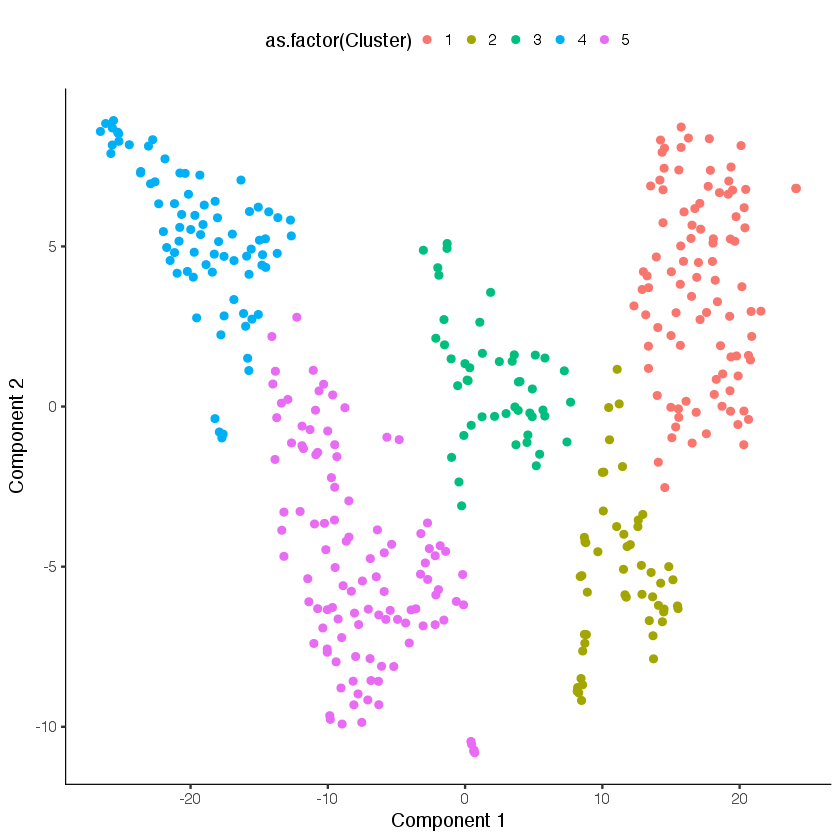

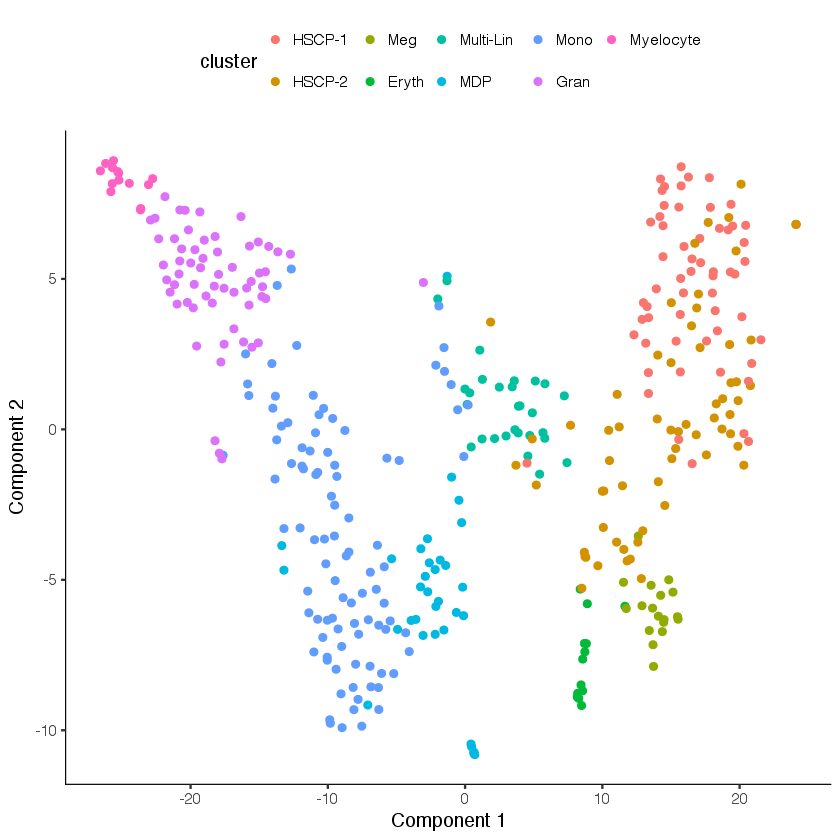

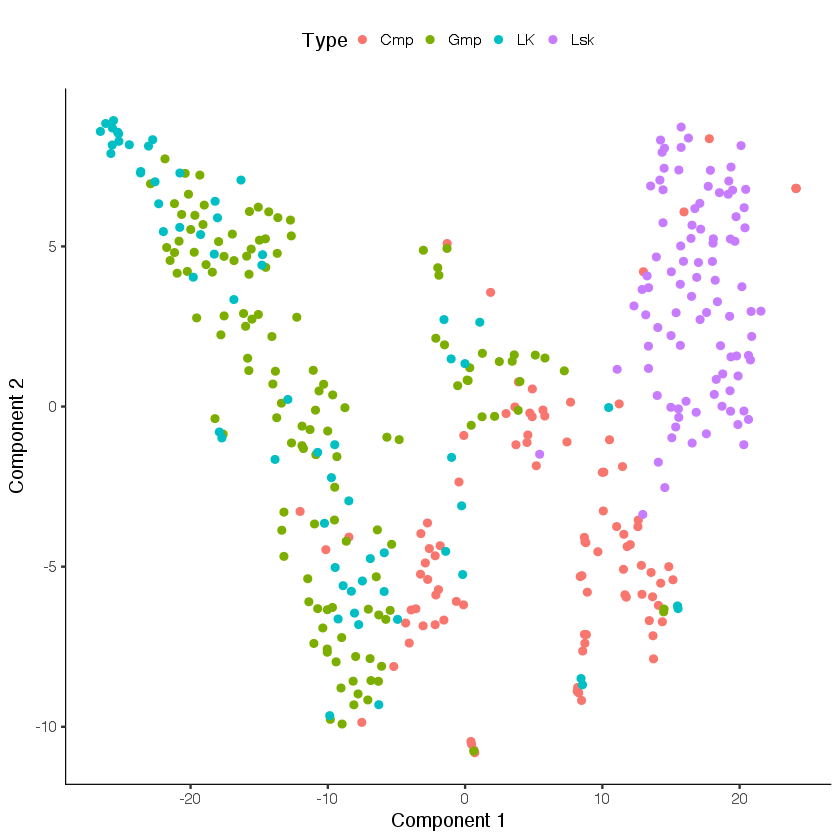

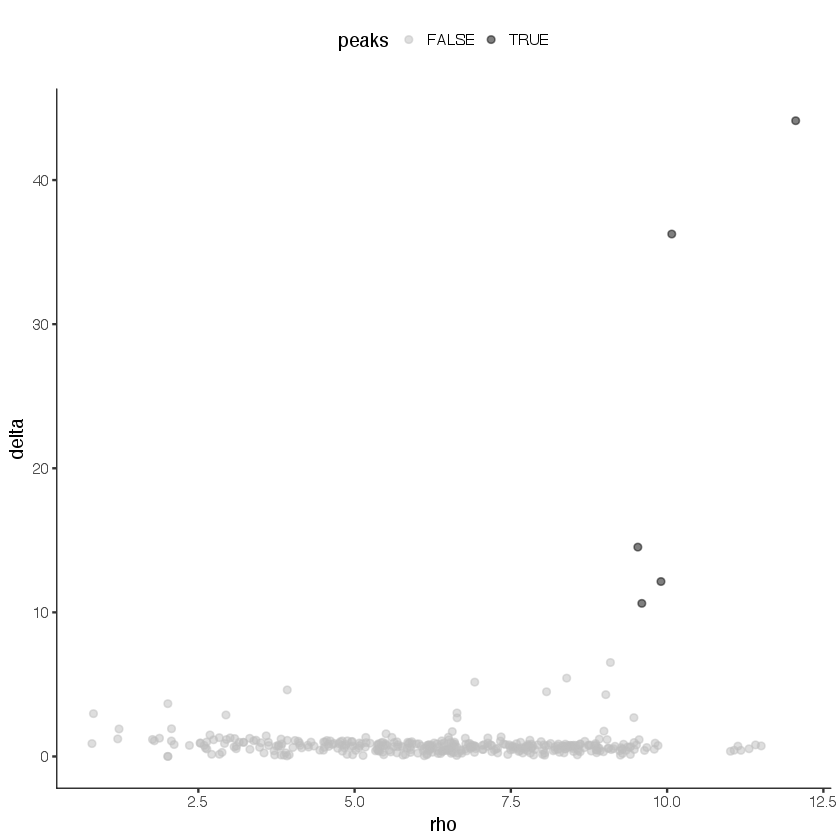

In [4]:
#1. set ordering genes for the fig1b
URMM_all_fig1b <- setOrderingFilter(URMM_all_fig1b, ordering_genes = row.names(fig1b))
URMM_pc_variance <- plot_pc_variance_explained(URMM_all_fig1b, return_all = T, norm_method = 'log')

#2. run reduceDimension with tSNE as the reduction_method
set.seed(2017)
URMM_all_fig1b <- reduceDimension(URMM_all_fig1b, max_components=2, norm_method = 'log', reduction_method = 'tSNE', num_dim = 12,  verbose = F)

#3. initial run of clusterCells
URMM_all_fig1b <- clusterCells(URMM_all_fig1b, verbose = F, num_clusters = 5)

#4. check the clusters
plot_cell_clusters(URMM_all_fig1b, color_by = 'as.factor(Cluster)') # show_density = F,
plot_cell_clusters(URMM_all_fig1b, color_by = 'cluster')
plot_cell_clusters(URMM_all_fig1b, color_by = 'Type')
plot_rho_delta(URMM_all_fig1b) 

URMM_all_fig1b@expressionFamily <- negbinomial.size()
pData(URMM_all_fig1b)$Cluster <- factor(pData(URMM_all_fig1b)$Cluster)
URMM_clustering_DEG_genes <- differentialGeneTest(URMM_all_fig1b, fullModelFormulaStr = '~Cluster', cores = detectCores() - 2)

#use all DEG gene from the clusters
URMM_ordering_genes <- row.names(URMM_clustering_DEG_genes)[order(URMM_clustering_DEG_genes$qval)][1:1000]

# Reconstruct the developmental trajectory for the wild-type data 
- use the feature genes selected above to reconstruct the developmental trajectory  

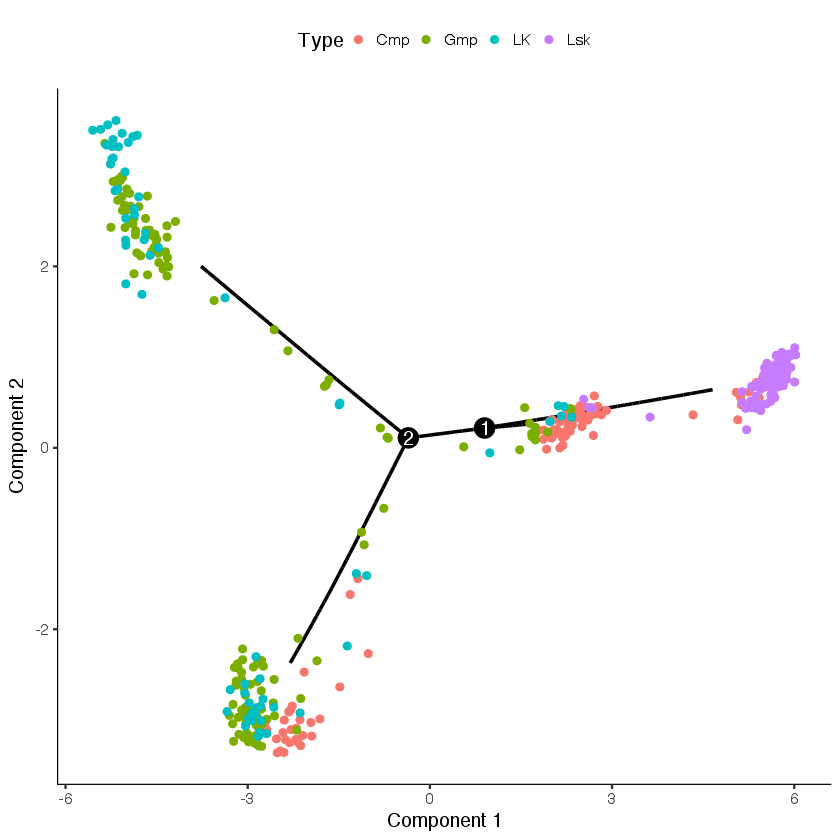

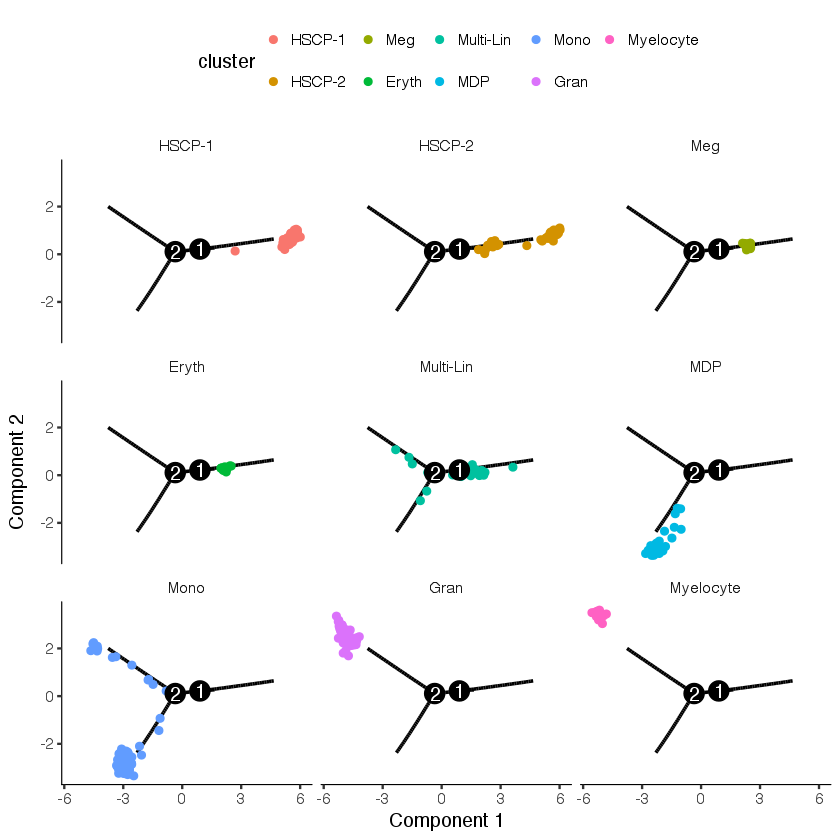

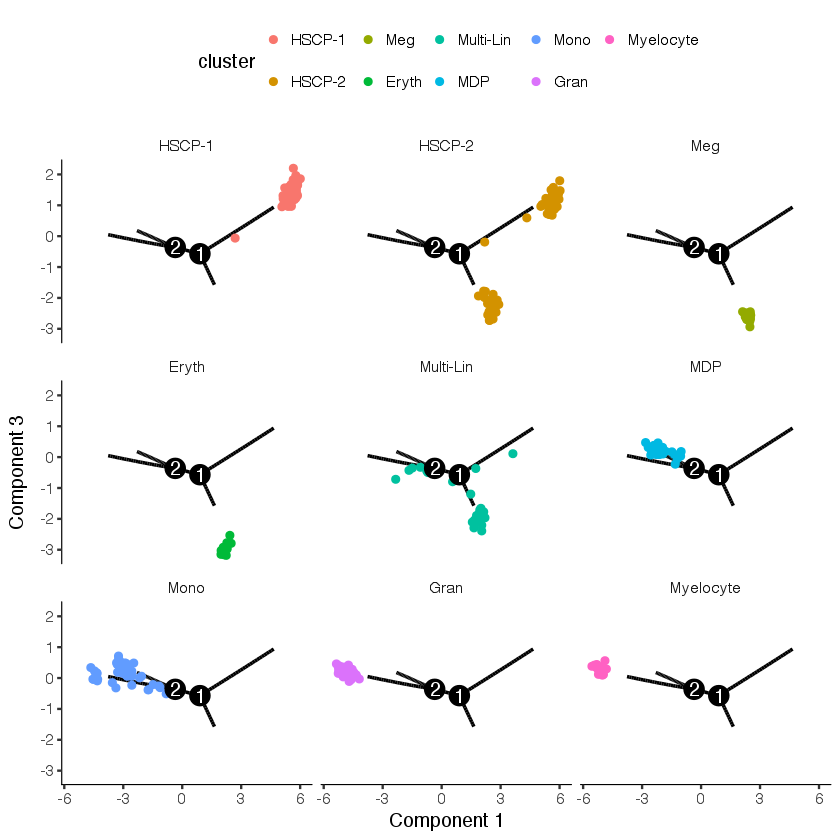

In [5]:
URMM_all_fig1b <- setOrderingFilter(URMM_all_fig1b, ordering_genes = c(URMM_ordering_genes))
URMM_all_fig1b <- reduceDimension(URMM_all_fig1b, verbose = F, scaling = T, max_components = 4, maxIter = 100, norm_method = 'log',  lambda = 20 * ncol(URMM_all_fig1b)) 
URMM_all_fig1b <- orderCells(URMM_all_fig1b)
plot_cell_trajectory(URMM_all_fig1b, color_by = 'Type')
plot_cell_trajectory(URMM_all_fig1b, color_by = 'cluster') + facet_wrap(~cluster)
plot_cell_trajectory(URMM_all_fig1b, color_by = 'cluster', x = 1, y = 3) + facet_wrap(~cluster)

# Reconstruct the developmental trajectory for all cells
- use the same set of genes as for the WT cells to reconstruct the developmental trajectory 
- as above, two branch points are discovered 

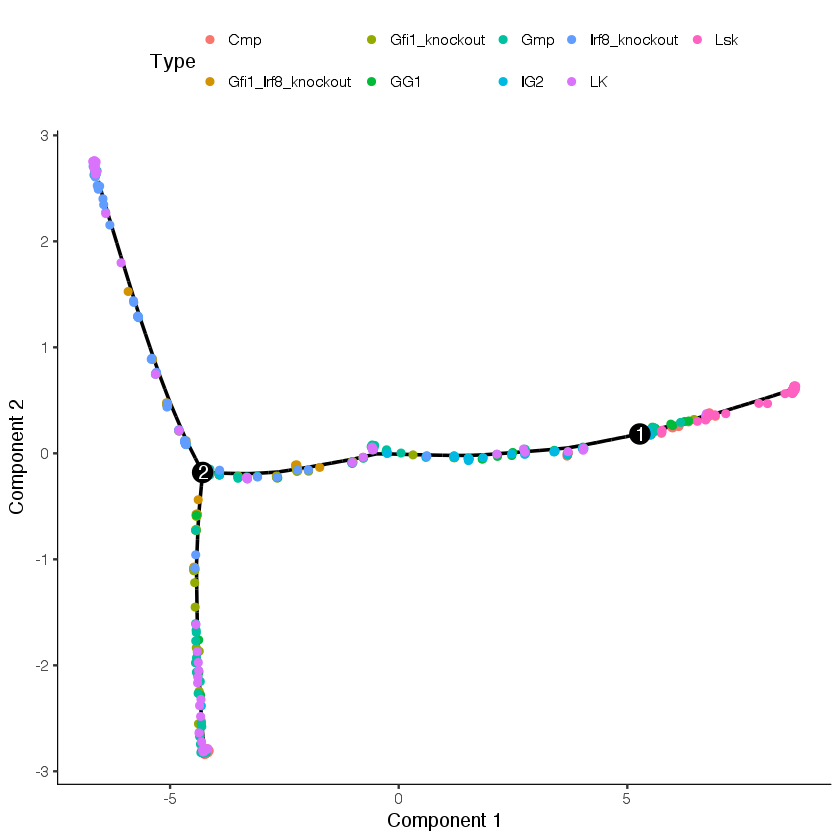

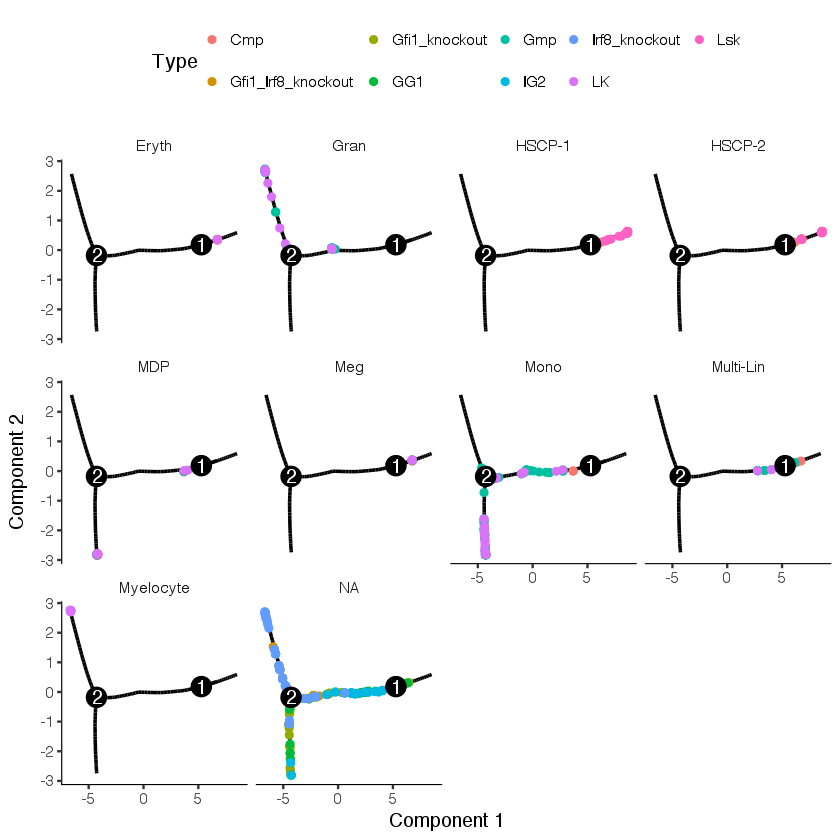

In [6]:
pData(URMM_all_abs)[colnames(URMM_all_fig1b), 'paper_cluster'] <- as.character(pData(URMM_all_fig1b)[, 'cluster'])

URMM_all_abs <- setOrderingFilter(URMM_all_abs, ordering_genes = URMM_ordering_genes)
URMM_all_abs <- reduceDimension(URMM_all_abs, verbose = F, scaling = T, maxIter = 100, norm_method = 'log', max_components = 4, param.gamma = 100, lambda = 14 * ncol(URMM_all_fig1b)) 
URMM_all_abs <- orderCells(URMM_all_abs)
plot_cell_trajectory(URMM_all_abs, color_by = 'Type')
plot_cell_trajectory(URMM_all_abs, color_by = 'Type') + facet_wrap(~paper_cluster)

# Show the complicate tree structure for WT and full dataset
- trajectories are reconstructed in 4 dimension but can be visualized as a tree layout in two dimensions 
- both of the WT and full dataset include the similar branch points 

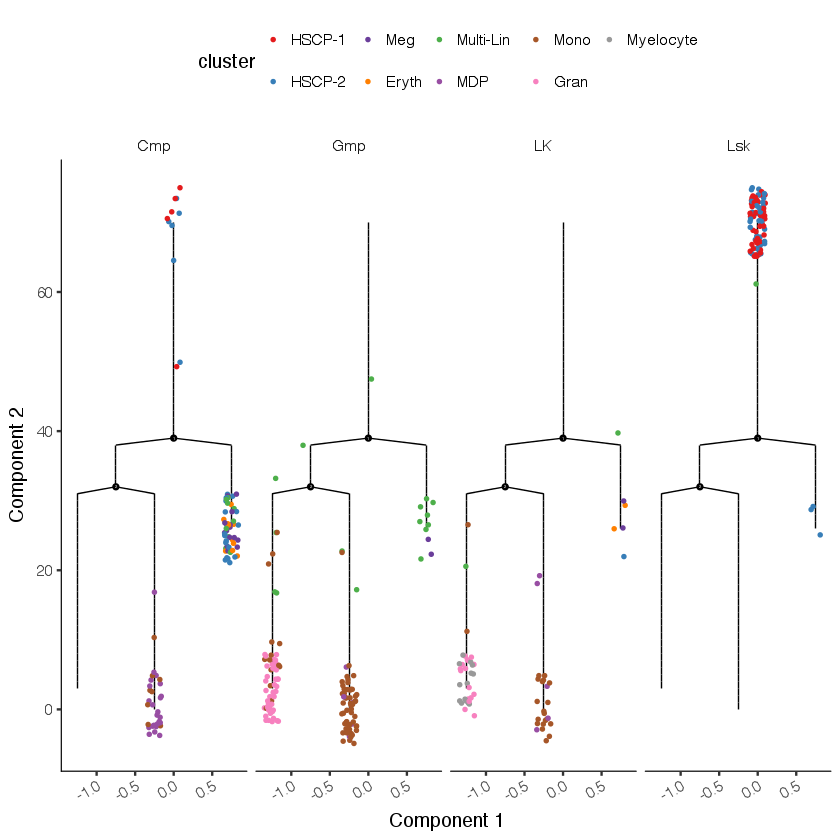

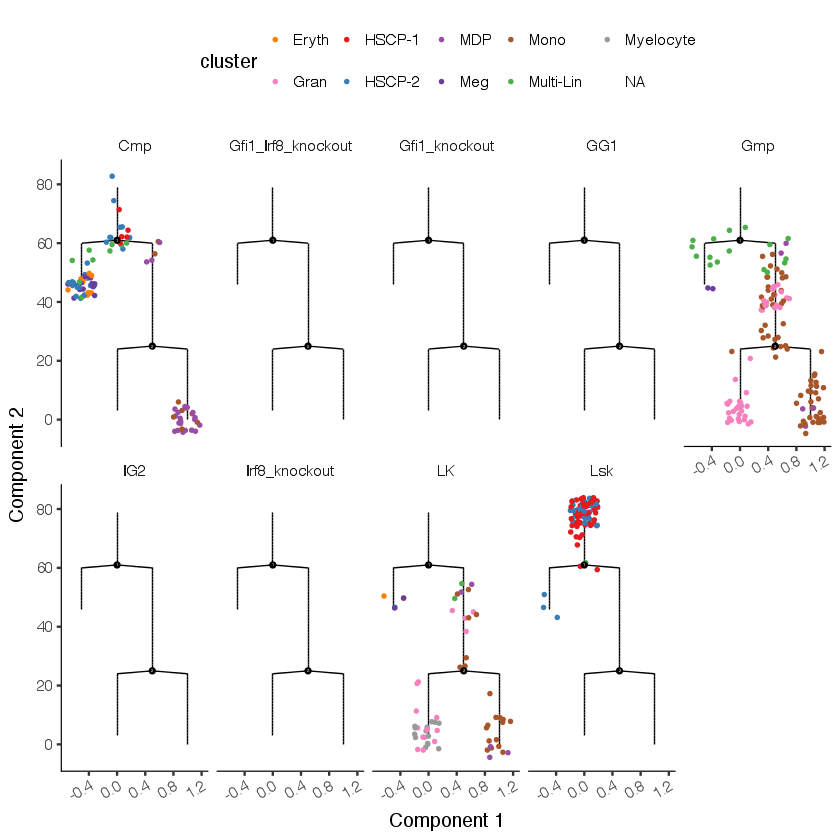

In [7]:
type_vec <- unique(pData(URMM_all_abs)$Type)
type_cols <- RColorBrewer::brewer.pal(9, name = 'Set1')
type_cols[6] <- "#6A3D9A"
names(type_cols) <- type_vec
 
cluster_vec <- unique(pData(URMM_all_fig1b)$cluster)
cluster_cols <- type_cols
cluster_cols[10] <- "#0600FC"
names(cluster_cols) <- cluster_vec

plot_complex_cell_trajectory(URMM_all_fig1b[, ], color_by = 'cluster', show_branch_points = T, cell_size = 0.5, cell_link_size = 0.3) + facet_wrap(~Type, nrow = 1) + scale_size(range = c(0.2, 0.2)) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1)) + scale_color_manual(values = cluster_cols, name = "cluster")

plot_complex_cell_trajectory(URMM_all_abs[, ], color_by = 'paper_cluster', show_branch_points = T, cell_size = 0.5, cell_link_size = 0.3) + facet_wrap(~Type, nrow = 2) + scale_size(range = c(0.2, 0.2)) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1)) + scale_color_manual(values = cluster_cols, name = "cluster") 

# Show the complicate tree structure on two dimension 
- as tree as above but visulize the tree structure in the first two dimension 

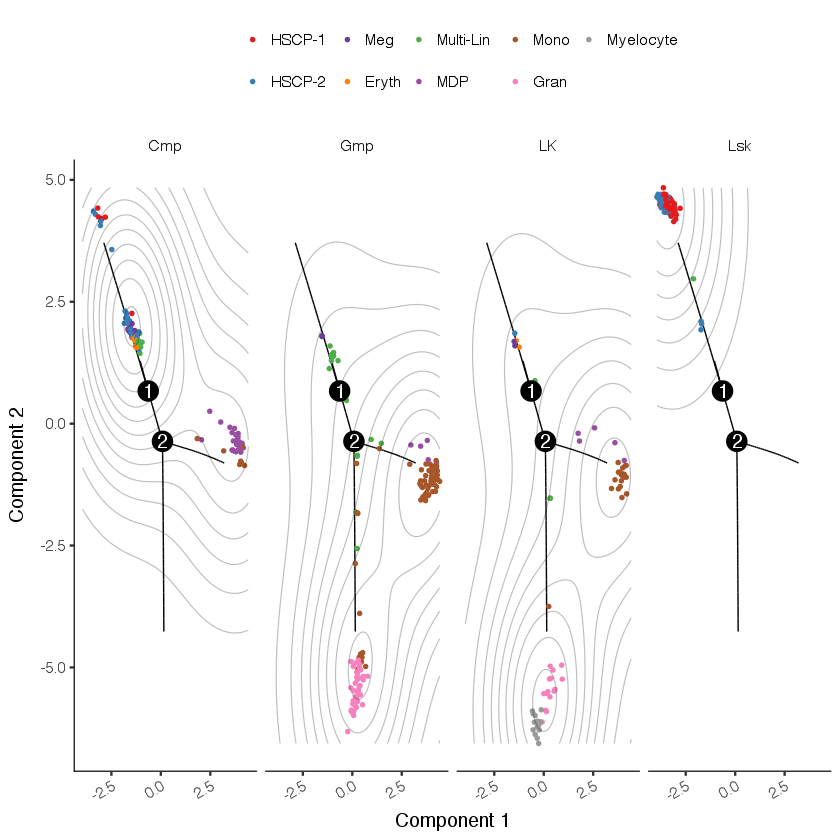

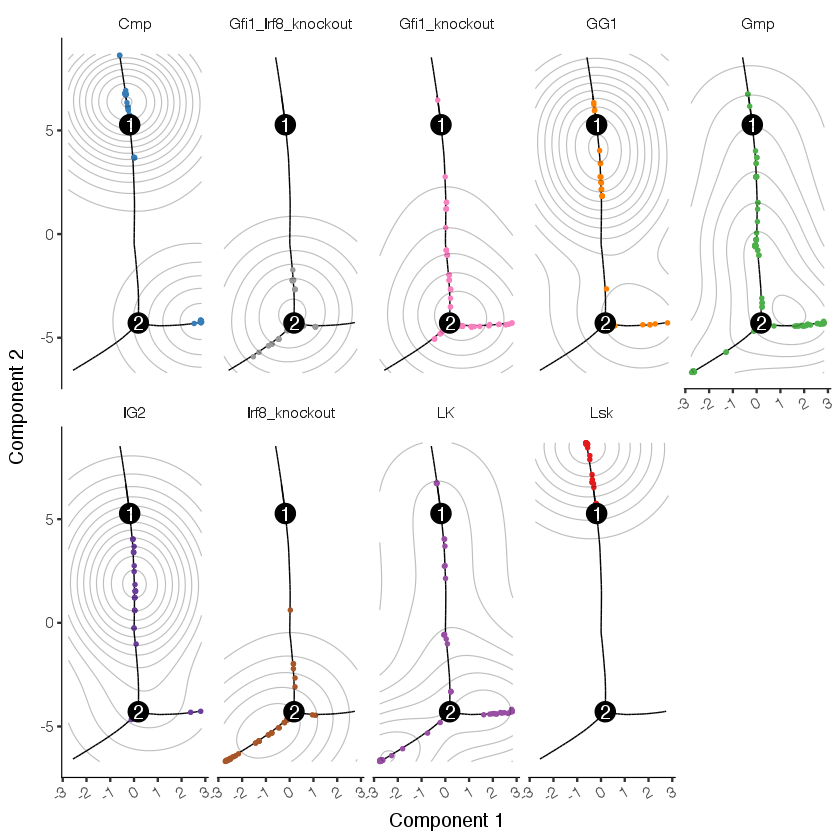

In [8]:
plot_cell_trajectory(URMM_all_fig1b[, ], color_by = 'cluster', show_branch_points = T, theta = 120, cell_size = 0.5, cell_link_size = 0.3) + facet_wrap(~Type, nrow = 1) + scale_size(range = c(0.2, 0.2)) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1)) + scale_color_manual(values = cluster_cols, name = "cluster") +theme (legend.position="right", legend.title=element_blank()) +
  stat_density2d(color='black', h = 8, alpha=I(0.25), size=I(0.25)) + theme (legend.position="top", legend.title=element_blank()) #theme(axis.text.x = element_text(angle = 30, hjust = 1))

plot_cell_trajectory(URMM_all_abs[, ], color_by = 'Type', show_branch_points = T, cell_size = 0.5, cell_link_size = 0.3, theta = 90) + facet_wrap(~Type, nrow = 2) + scale_size(range = c(0.2, 0.2)) +
  theme(axis.text.x = element_text(angle = 30, hjust = 1)) + scale_color_manual(values = type_cols, name = "Type")  + theme (legend.position="none", legend.title=element_blank()) +
  stat_density2d(color='black', h = 8, alpha=I(0.25), size=I(0.25))

# Cell type distribution over the tree structure 
- we can visualize the fraction of cell types over each state of the tree structure in a heatmap 
- both heatmaps show that our method is able to put distinct cell types to different state (branch) of the learned tree structure 

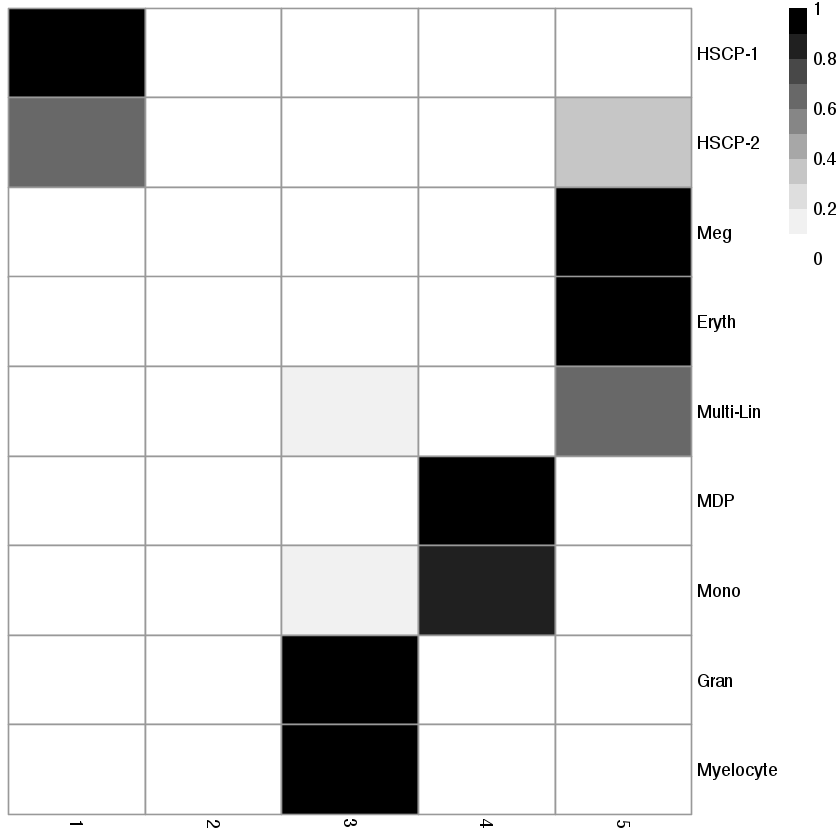

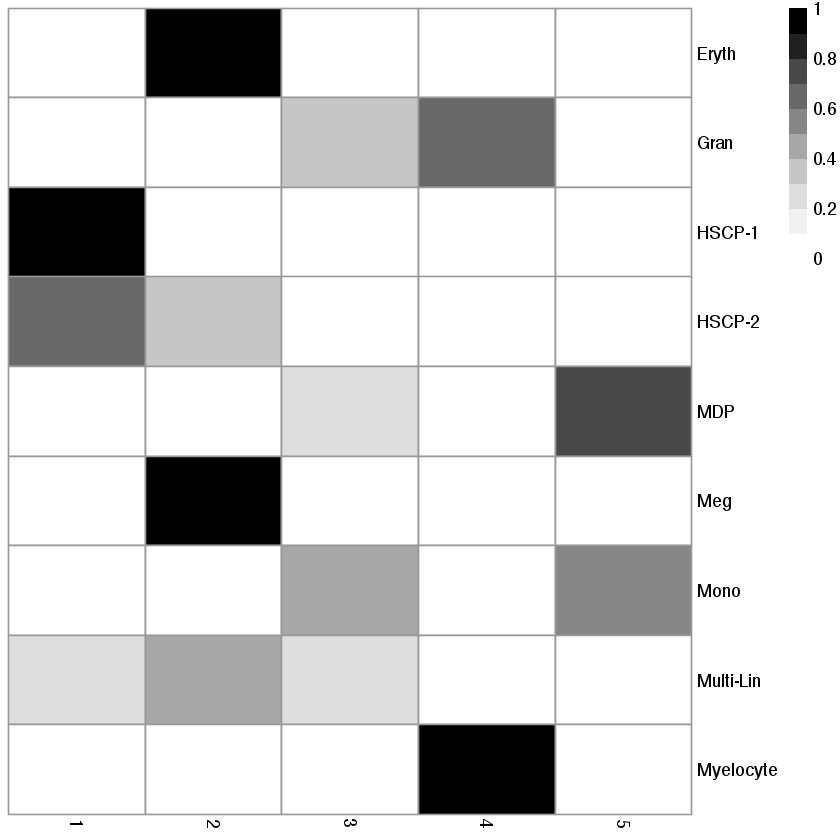

In [9]:
state_cluster_stat <- table(pData(URMM_all_fig1b)[, c('State', 'cluster')])

state_cluster_stat <- apply(state_cluster_stat, 2, function(x) x / sum(x))
state_cluster_stat_ordered <- t(state_cluster_stat)

pheatmap::pheatmap(state_cluster_stat_ordered, cluster_cols = F, cluster_rows = F, color = colorRampPalette(RColorBrewer::brewer.pal(n=9, name='Greys'))(10))

state_cluster_stat <- table(pData(URMM_all_abs)[, c('State', 'paper_cluster')])

state_cluster_stat <- apply(state_cluster_stat, 2, function(x) x / sum(x))
state_cluster_stat_ordered <- t(state_cluster_stat)

pheatmap::pheatmap(state_cluster_stat_ordered, cluster_cols = F, cluster_rows = F, color = colorRampPalette(RColorBrewer::brewer.pal(n=9, name='Greys'))(10))


# Identify the genes which can be used to define stemness or lineage score 
- genes used to define stemness or lineage score are identified
- those genes will also be used for the Paul dataset analysis 

In [ ]:
fig1b_beam_genes_ery_meg <- BEAM(URMM_all_fig1b, branch_point = 1, verbose = F, cores = detectCores() - 2)
fig1b_beam_genes_ery_meg_ILRs <- calILRs(URMM_all_fig1b, branch_point = 1, verbose = F, cores = detectCores() - 2)

fig1b_beam_genes_ery_meg_ILRs_all <- calILRs(URMM_all_fig1b, branch_point = 1, verbose = F, cores = detectCores() - 2, return_all = T)
URMM_all_absbeam_genes_ery_meg_ILRs_all <- calILRs(URMM_all_abs, branch_point = 1, verbose = F, cores = detectCores() - 2, return_all = T)

initial_reference_val_ery <- rowMeans(fig1b_beam_genes_ery_meg_ILRs_all$str_branchA_expression_curve_matrix[, 25:30])
initial_reference_val_gmp <- rowMeans(fig1b_beam_genes_ery_meg_ILRs_all$str_branchB_expression_curve_matrix[, 25:30])

diff_reference_ery <- fig1b_beam_genes_ery_meg_ILRs_all$str_branchA_expression_curve_matrix[, 31:100] - matrix(rep(initial_reference_val_ery, 70), ncol = 70)
diff_reference_gmp <- fig1b_beam_genes_ery_meg_ILRs_all$str_branchB_expression_curve_matrix[, 31:55] - matrix(rep(initial_reference_val_gmp, 25), ncol = 25)

all_down <- apply(diff_reference_ery, 1, function(x) all(x < 0)) & apply(diff_reference_gmp, 1, function(x) all(x < 0))

URMM_all_fig1b_MEP <- URMM_all_fig1b[, pData(URMM_all_fig1b)$State %in% c(1, 5)]
URMM_all_fig1b_GMP <- URMM_all_fig1b[, pData(URMM_all_fig1b)$State %in% c(1:4)]
fig1b_pseudotime_MEP <- differentialGeneTest(URMM_all_fig1b_MEP, verbose = F, cores = detectCores() - 2)
fig1b_pseudotime_GMP <- differentialGeneTest(URMM_all_fig1b_GMP, verbose = F, cores = detectCores() - 2)    

# Visualize the lineage score and stemness score on the tree  
- color the tree by the lineage / stemness score to verify the continous transition of cell states

In [ ]:
load('./valid_subset_GSE72857_cds2') #126 nodes in 10 dimensions
ery_meg_lineage_score <- rowMeans(fig1b_beam_genes_ery_meg_ILRs)[row.names(subset(fig1b_beam_genes_ery_meg, qval <0.01))]

positive_score_genes <- intersect(row.names(valid_subset_GSE72857_cds2), names(ery_meg_lineage_score[ery_meg_lineage_score > 0.5])) #positive genes (Ery/Meg lineage)
negtive_score_genes <- intersect(row.names(valid_subset_GSE72857_cds2), names(ery_meg_lineage_score[ery_meg_lineage_score < -0.5])) #negative genes (GMP lineage)

cell_ery_meg_lineage_score <- esApply(URMM_all_fig1b[c(positive_score_genes, negtive_score_genes), ], 2, function(x) mean(x[1:length(positive_score_genes)]) - mean(x[length(positive_score_genes):length(x)]))

pData(URMM_all_fig1b)$ery_meg_lineage_score <- cell_ery_meg_lineage_score
plot_complex_cell_trajectory(URMM_all_fig1b, color_by = 'ery_meg_lineage_score', show_branch_points = T, cell_link_size = 0.5, cell_size = 1) +
scale_colour_gradient2() + scale_x_reverse() +
 theme(axis.text.x = element_text(angle = 30, hjust = 1)) + theme (legend.position="right", legend.title=element_blank()) +
theme(legend.position="top", legend.title=element_blank()) + theme (legend.position="none", legend.title=element_blank()) + theme_void() + theme (legend.position="none", legend.title=element_blank())

pseudotime_degs <- intersect(row.names(subset(fig1b_pseudotime_MEP, qval < 0.01)), row.names(subset(fig1b_pseudotime_GMP, qval < 0.01)))
all_down_valid <- Reduce(intersect, list(row.names(valid_subset_GSE72857_cds2), names(all_down[all_down]), pseudotime_degs))

cell_stemness_score <- esApply(URMM_all_fig1b[all_down_valid, ], 2, function(x) mean(x))
pData(URMM_all_fig1b)$cell_stemness_score <- cell_stemness_score
plot_complex_cell_trajectory(URMM_all_fig1b, color_by = 'cell_stemness_score') +  scale_colour_gradientn(colours = terrain.colors(10))


# Save the data for using in the Paul dataset 
- all_down_valid: associate with the stemness score 
- positive_score_genes, negtive_score_genes: associate with the lineage score 

In [ ]:
save(all_down_valid, positive_score_genes, negtive_score_genes, file = 'gene_set')

# Create the multi-way kinetic curves as well as the heatmap
- we can visualize the gene expression dynamics over fate commitment either with the multi-way kinetic curves 
- or the multi-way heatmap 

In [ ]:
plot_multiple_branches_pseudotime(URMM_all_fig1b[c('Car1', 'Elane', 'Car2', 'Prtn3'),],
                                  branches=c(3, 4, 5), color_by = 'Branch',
                                  branches_name=c("Granulocyte", "Monocyte", "Ery/Meg"), nrow = 2, ncol = 2) +
  scale_color_manual(values = URMM_complex_tree_ery_meg_lineage_score_kinetic_curves_cols)
plot_multiple_branches_heatmap(URMM_all_fig1b[unique(c(positive_score_genes, negtive_score_genes)),],
                               branches=c(3, 4, 5),
                               branches_name=c("Granulocyte", "Monocyte", "Ery/Meg"),
                               show_rownames=T,
                               num_clusters=4)

# Show the regulatory network 
- this network is created based on the BEAM analysis, ChIP-seq as well as the motif-scanning analysis 

In [ ]:
load("./network_res")

plot.netbiov(res) # create the hiearchical network 

# Show the session information 

In [ ]:
sessionInfo()